In [1]:
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Dropout, BatchNormalization, MaxPooling3D, Flatten, ConvLSTM2D, Rescaling
import tensorflow.keras.preprocessing as tf_preprocessing
from keras.optimizers import Adam
from keras.utils import to_categorical
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

from tqdm import tqdm
import wandb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback

In [2]:
# pip uninstall keras -y && pip uninstall keras-nightly -y && pip uninstall keras-Preprocessing -y && pip uninstall keras-vis -y && pip uninstall tensorflow -y
 
# pip install tensorflow && pip install keras

### Wandb stuff

In [3]:
config_defaults = {
    'epochs': 5,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'dropout': 0.3,
}
wandb.init(config=config_defaults, project="deepfake-lstm", entity="dat550")
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dat550 (use `wandb login --relogin` to force relogin)


### Prepare data

In [4]:
# hack, to forche length of 22
len_22_ds = np.full((1, 128, 128, 3), 1)
len_22_ds.shape

(1, 128, 128, 3)

In [5]:
def get_file_dict(folder):
    onlyfiles = [f for f in listdir(folder) if isfile(join(folder, f))]
    file_dict = {}
    for file in onlyfiles:
        video_name = file.split(".")[0][0:10]
        if video_name not in file_dict:
            file_dict[video_name] = []
        file_dict[video_name].append(file)


    # sort file_dict values
    for key in file_dict:
        file_dict[key] = sorted(file_dict[key], key=lambda x: int(x.split(".")[0][10:]))
    return file_dict

def load_image_to_array(path):
    image = tf_preprocessing.image.load_img(path)
    input_arr = tf_preprocessing.image.img_to_array(image)
    return input_arr

def load_list_of_inmages_to_array(list_of_images, folder):
    input_arr = []
    for image in list_of_images:
        input_arr.append(load_image_to_array(f'{folder}/{image}'))
    return np.array(input_arr)

def get_padded_video_data(folder):
    labels = ["REAL", "FAKE"]

    all_data = []
    label_arr = []

    for i, label in enumerate(labels):
        file_dict = get_file_dict(folder + f"/{label}")
        for key in tqdm(file_dict):
            all_data.append(load_list_of_inmages_to_array(file_dict[key], f"{folder}/{label}"))
            label_arr.append(i)

    # add len_22_ds to all_data
    all_data.append(len_22_ds)

    # convert and pad data
    all_data = np.array(all_data)
    label_arr = np.array(label_arr)
    

    padded_data = tf_preprocessing.sequence.pad_sequences(
    all_data,
    maxlen=22, # TODO: fjern dette en dag
    dtype='int32',
    # padding='pre',
    # truncating='pre',
    # value=0.0,
    )

    # remove len_22_ds from padded_data
    padded_data = padded_data[:-1]

    return padded_data, label_arr

### Define model

In [10]:
model = Sequential([
    Rescaling(1./255),
    Conv3D(filters=32, kernel_size=(2,2,2),input_shape=(22, 128, 128, 3),
        activation='relu', padding='same', data_format='channels_last'),
    BatchNormalization(),

    ConvLSTM2D(filters=16, kernel_size=(2, 2), padding='same', return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    MaxPooling3D(pool_size=(2,2,2)),

    ConvLSTM2D(filters=16, kernel_size=(2, 2),
    padding='same', return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    MaxPooling3D(pool_size=(2,2,2)),

    Flatten(),
    BatchNormalization(),
    Dense(32,activation='elu'),
    Dense(1,activation='sigmoid'),
])

optimizer = Adam(lr=config.learning_rate)
model.build((None, 22, 128, 128, 3)) 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

c:\Users\henriks\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 22, 128, 128, 3)   0         
                                                                 
 conv3d_4 (Conv3D)           (None, 22, 128, 128, 32)  800       
                                                                 
 batch_normalization_16 (Bat  (None, 22, 128, 128, 32)  128      
 chNormalization)                                                
                                                                 
 conv_lstm2d_8 (ConvLSTM2D)  (None, 22, 128, 128, 16)  12352     
                                                                 
 batch_normalization_17 (Bat  (None, 22, 128, 128, 16)  64       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 22, 128, 128, 16) 

### Train model

In [11]:
# Get data
# takes approx 2 min
folder = "./data/data-large/data/train"
train_x, train_y = get_padded_video_data(folder) 

100%|██████████| 1814/1814 [00:21<00:00, 84.49it/s] 
C:\Users\henriks\AppData\Local\Temp/ipykernel_22400/117894631.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_data = np.array(all_data)


In [12]:
train_x

array([[[[[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         ...,

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
         

In [13]:
# get validation data
folder = "./data/data-large/data/validation"
val_x, val_y = get_padded_video_data(folder) 

100%|██████████| 1053/1053 [00:02<00:00, 385.00it/s]
C:\Users\henriks\AppData\Local\Temp/ipykernel_22400/117894631.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_data = np.array(all_data)


In [14]:
print(f"train_x shape: {train_x.shape}, train_y shape: {train_y.shape}")
print(f"val_x shape: {val_x.shape}, val_y shape: {val_y.shape}")

train_x shape: (3702, 22, 128, 128, 3), train_y shape: (3702,)
val_x shape: (2168, 22, 128, 128, 3), val_y shape: (2168,)


In [15]:
# Wandb stuff
model_file = f'f{wandb.run.name}_model.h5'

custom_callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        mode = 'min',
        patience = 5,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = model_file,
        monitor = 'val_loss',
        mode = 'min',
        verbose = 1,
        save_best_only = True
    ),
    WandbCallback()
]

In [17]:
RUN_LOCAL = False
if RUN_LOCAL:
    # slice the data for testing:
    n = 20
    index = np.random.choice(train_x.shape[0], n, replace=False)

    short_train_x = train_x[index]
    short_train_y = train_y[index]
    print(f"train_x shape: {short_train_x.shape}, train_y shape: {short_train_y.shape}")
    train_x = short_train_x
    train_y = short_train_y

history = model.fit(train_x, train_y, epochs=config.epochs, batch_size=config.batch_size,
    validation_data = (val_x, val_y),
    callbacks = custom_callbacks)

Epoch 1/5


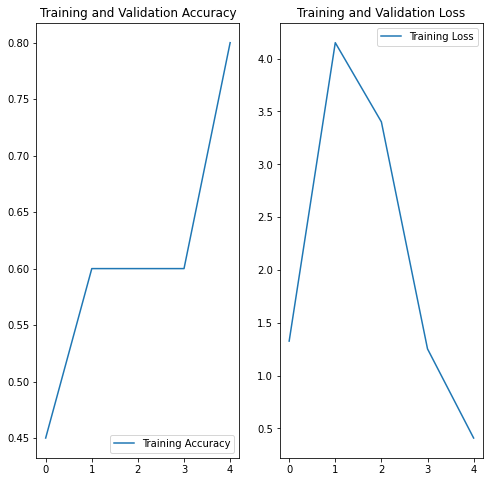

In [ ]:
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluate model

In [ ]:
# Get tets data
folder = "./data/data-large/data/test"
test_x, test_y = get_padded_video_data(folder) 
print(f"train_x shape: {test_x.shape}, train_y shape: {test_y.shape}")

In [ ]:
# evaluate model
scores = model.evaluate(test_x, test_y, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))




# predictions = model.predict(test_x)
# predictions = np.round(predictions)
# predictions = predictions.astype(int)


5/5 [==============================] - 45s 9s/step - loss: 0.7114 - accuracy: 0.4933
Accuracy: 49.33%
